#ANDROID APP SECURITY CLASSIFIER

### Load Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc


###Data Preparation and Visualization

In [2]:
df = pd.read_csv('/content/data.csv')

In [3]:
df.head()

,android.permission.GET_ACCOUNTS,com.sonyericsson.home.permission.BROADCAST_BADGE,android.permission.READ_PROFILE,android.permission.MANAGE_ACCOUNTS,android.permission.WRITE_SYNC_SETTINGS,android.permission.READ_EXTERNAL_STORAGE,android.permission.RECEIVE_SMS,com.android.launcher.permission.READ_SETTINGS,android.permission.WRITE_SETTINGS,com.google.android.providers.gsf.permission.READ_GSERVICES,...,com.android.launcher.permission.UNINSTALL_SHORTCUT,com.sec.android.iap.permission.BILLING,com.htc.launcher.permission.UPDATE_SHORTCUT,com.sec.android.provider.badge.permission.WRITE,android.permission.ACCESS_NETWORK_STATE,com.google.android.finsky.permission.BIND_GET_INSTALL_REFERRER_SERVICE,com.huawei.android.launcher.permission.READ_SETTINGS,android.permission.READ_SMS,android.permission.PROCESS_INCOMING_CALLS,Result
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29332 entries, 0 to 29331
Data columns (total 87 columns):
 #   Column                                                                         Non-Null Count  Dtype
---  ------                                                                         --------------  -----
 0   android.permission.GET_ACCOUNTS                                                29332 non-null  int64
 1   com.sonyericsson.home.permission.BROADCAST_BADGE                               29332 non-null  int64
 2   android.permission.READ_PROFILE                                                29332 non-null  int64
 3   android.permission.MANAGE_ACCOUNTS                                             29332 non-null  int64
 4   android.permission.WRITE_SYNC_SETTINGS                                         29332 non-null  int64
 5   android.permission.READ_EXTERNAL_STORAGE                                       29332 non-null  int64
 6   android.permission.RECEIVE_SMS        

In [5]:
df.shape

(29332, 87)

In [6]:
df.isnull().sum()

android.permission.GET_ACCOUNTS                                           0
com.sonyericsson.home.permission.BROADCAST_BADGE                          0
android.permission.READ_PROFILE                                           0
android.permission.MANAGE_ACCOUNTS                                        0
android.permission.WRITE_SYNC_SETTINGS                                    0
                                                                         ..
com.google.android.finsky.permission.BIND_GET_INSTALL_REFERRER_SERVICE    0
com.huawei.android.launcher.permission.READ_SETTINGS                      0
android.permission.READ_SMS                                               0
android.permission.PROCESS_INCOMING_CALLS                                 0
Result                                                                    0
Length: 87, dtype: int64

In [7]:
constants = [
    val for val in df.columns if len(df[val].fillna(0).unique()) == 1
]

constants

[]

In [8]:
duplicate_variables = []
for i in range(0, len(df.columns)):
    orig = df.columns[i]

    for dupe in df.columns[i + 1:]:
        if df[orig].equals(df[dupe]):
            duplicate_variables.append(dupe)
            print(f'{orig} looks the same as {dupe}')

duplicate_variables

me.everything.badger.permission.BADGE_COUNT_WRITE looks the same as me.everything.badger.permission.BADGE_COUNT_READ


['me.everything.badger.permission.BADGE_COUNT_READ']

In [9]:
df.drop(['me.everything.badger.permission.BADGE_COUNT_READ'], axis=1, inplace=True)
df.shape

(29332, 86)

1    14700
0    14632
Name: Result, dtype: int64


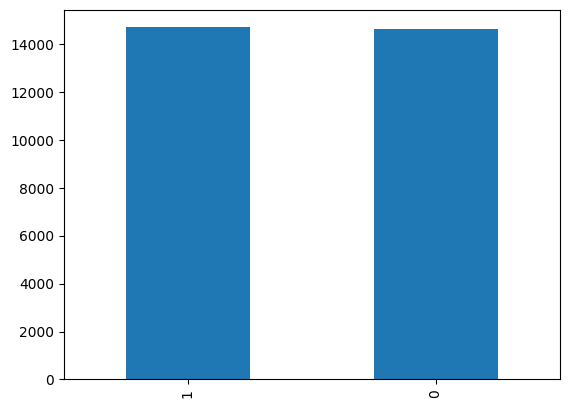

In [10]:
def visualize_class_distribution(df):
    print(df['Result'].value_counts())
    df['Result'].value_counts().plot(kind='bar')

visualize_class_distribution(df)

Our dataset is balanced so no need for oversampling

In [11]:
df.describe()

,android.permission.GET_ACCOUNTS,com.sonyericsson.home.permission.BROADCAST_BADGE,android.permission.READ_PROFILE,android.permission.MANAGE_ACCOUNTS,android.permission.WRITE_SYNC_SETTINGS,android.permission.READ_EXTERNAL_STORAGE,android.permission.RECEIVE_SMS,com.android.launcher.permission.READ_SETTINGS,android.permission.WRITE_SETTINGS,com.google.android.providers.gsf.permission.READ_GSERVICES,...,com.android.launcher.permission.UNINSTALL_SHORTCUT,com.sec.android.iap.permission.BILLING,com.htc.launcher.permission.UPDATE_SHORTCUT,com.sec.android.provider.badge.permission.WRITE,android.permission.ACCESS_NETWORK_STATE,com.google.android.finsky.permission.BIND_GET_INSTALL_REFERRER_SERVICE,com.huawei.android.launcher.permission.READ_SETTINGS,android.permission.READ_SMS,android.permission.PROCESS_INCOMING_CALLS,Result
count,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.00000,29332.000000,...,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000,29332.000000
mean,0.226033,0.034263,0.045888,0.013603,0.005762,0.171690,0.060071,0.014114,0.11080,0.043741,...,0.029660,0.003887,0.033445,0.034297,0.949032,0.023728,0.023387,0.051718,0.003648,0.501159
std,0.418268,0.181907,0.209247,0.115837,0.075688,0.377117,0.237622,0.117964,0.31389,0.204521,...,0.169652,0.062222,0.179798,0.181994,0.219937,0.152204,0.151133,0.221461,0.060289,0.500007
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###Building, Training, and Evaluating the Model

In [12]:
X = torch.FloatTensor(df.drop('Result', axis=1).values)
y = torch.FloatTensor(df['Result'].values).view(-1, 1)

#### i. Building the model

In [13]:
class AndroidSecurityClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(AndroidSecurityClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # Add a sigmoid activation function

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


#### ii. Training and Evaluation

Epoch 1/100: Train Accuracy = 0.6810, Validation Accuracy = 0.6958
Epoch 2/100: Train Accuracy = 0.8314, Validation Accuracy = 0.8432
Epoch 3/100: Train Accuracy = 0.8789, Validation Accuracy = 0.8947
Epoch 4/100: Train Accuracy = 0.9008, Validation Accuracy = 0.9133
Epoch 5/100: Train Accuracy = 0.9145, Validation Accuracy = 0.9239
Epoch 6/100: Train Accuracy = 0.9223, Validation Accuracy = 0.9258
Epoch 7/100: Train Accuracy = 0.9295, Validation Accuracy = 0.9337
Epoch 8/100: Train Accuracy = 0.9280, Validation Accuracy = 0.9292
Epoch 9/100: Train Accuracy = 0.9289, Validation Accuracy = 0.9330
Epoch 10/100: Train Accuracy = 0.9256, Validation Accuracy = 0.9288
Epoch 11/100: Train Accuracy = 0.9255, Validation Accuracy = 0.9292
Epoch 12/100: Train Accuracy = 0.9258, Validation Accuracy = 0.9303
Epoch 13/100: Train Accuracy = 0.9275, Validation Accuracy = 0.9322
Epoch 14/100: Train Accuracy = 0.9284, Validation Accuracy = 0.9326
Epoch 15/100: Train Accuracy = 0.9288, Validation Accurac

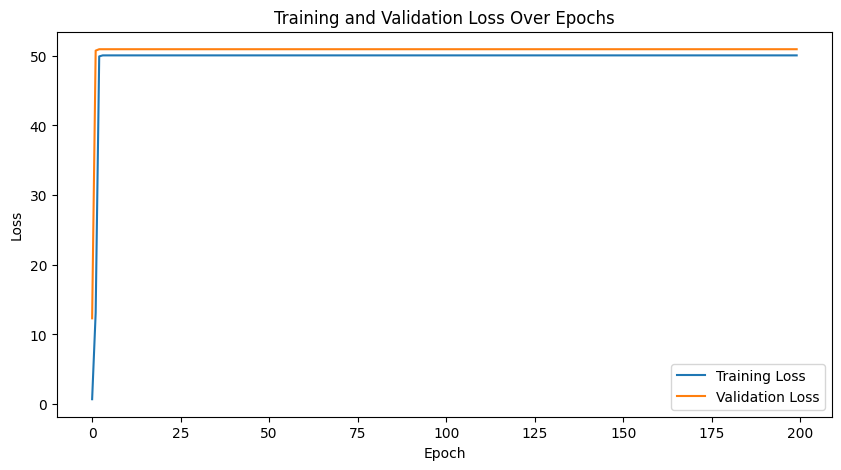

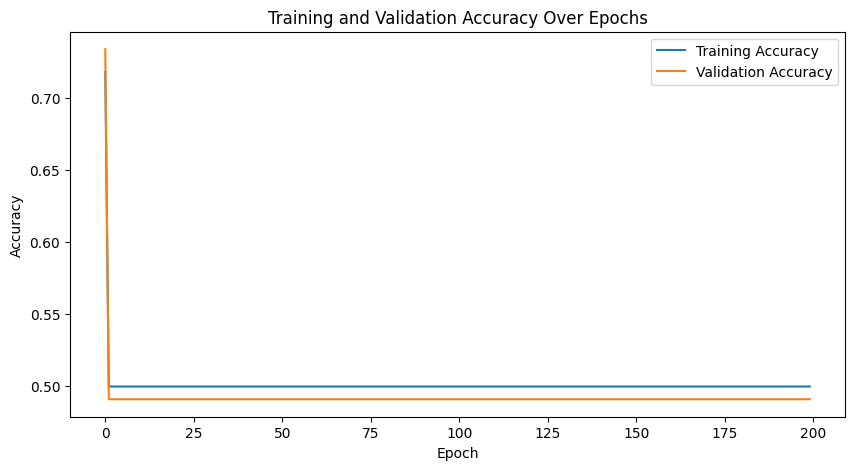

In [14]:
def custom_confusion_matrix(y_true, y_pred):
    true_positive = torch.sum((y_true == 1) & (y_pred == 1)).item()
    false_positive = torch.sum((y_true == 0) & (y_pred == 1)).item()
    true_negative = torch.sum((y_true == 0) & (y_pred == 0)).item()
    false_negative = torch.sum((y_true == 1) & (y_pred == 0)).item()

    return torch.tensor([[true_negative, false_positive],
                         [false_negative, true_positive]])

def custom_accuracy_score(y_true, y_pred):
    correct_predictions = torch.sum(y_true == y_pred).item()
    total_samples = len(y_true)
    accuracy = correct_predictions / total_samples
    return accuracy

def custom_train_test_split(X, y, test_size=0.25, random_state=None):
    if random_state is not None:
        torch.manual_seed(random_state)

    indices = torch.randperm(X.shape[0])
    num_test_samples = int(test_size * X.shape[0])

    test_indices = indices[:num_test_samples]
    train_indices = indices[num_test_samples:]

    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

def train_model_with_metrics(X_train, y_train, X_val, y_val, model, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_pred_train = (model(X_train) >= 0.5).float()
            train_accuracy = custom_accuracy_score(y_train, y_pred_train)

        model.eval()
        with torch.no_grad():
            y_pred_val = (model(X_val) >= 0.5).float()
            val_loss = criterion(model(X_val), y_val)
            val_accuracy = custom_accuracy_score(y_val, y_pred_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Accuracy = {train_accuracy:.4f}, "
              f"Validation Accuracy = {val_accuracy:.4f}")

    return model, train_losses, val_losses, val_accuracies, train_accuracies



X_train, X_temp, y_train, y_temp = custom_train_test_split(X, y, test_size=0.1, random_state=42)
X_val, X_test, y_val, y_test = custom_train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

input_size = X_train.shape[1]
output_size = 1

learning_rates = [0.01, 0.1, 0.5]
num_epochs_list = [100, 150, 200]
hidden_sizes = [64, 128, 256]

best_accuracy = 0.0
best_lr = None
best_epochs = None
best_hidden_size = None
best_model = None

for lr in learning_rates:
    for num_epochs in num_epochs_list:
        for hidden_size in hidden_sizes:
            model = AndroidSecurityClassifier(input_size, hidden_size, output_size)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            y_train_float = y_train.float()
            y_val_float = y_val.float()

            trained_model, train_losses, val_losses, val_accuracies, train_accuracies = train_model_with_metrics(
            X_train, y_train_float, X_val, y_val_float, model, criterion, optimizer, num_epochs)


            print(f"\nLearning Rate: {lr}, Epochs: {num_epochs}, Hidden Size: {hidden_size}, "
                  f"Validation Accuracy: {val_accuracies[-1]:.4f}\n")

            if val_accuracies[-1] > best_accuracy:
                best_accuracy = val_accuracies[-1]
                best_lr = lr
                best_epochs = num_epochs
                best_hidden_size = hidden_size
                best_model = trained_model

print(f"Best Learning Rate: {best_lr}, Best Epochs: {best_epochs}, Best Hidden Size: {best_hidden_size}, "
      f"Best Validation Accuracy: {best_accuracy:.4f}")

if best_model is not None:
    best_model.eval()
    with torch.no_grad():
        y_pred_test = (best_model(X_test) >= 0.5).float()
        test_accuracy = custom_accuracy_score(y_test, y_pred_test)
        print(f"\nTest Accuracy with Best Model: {test_accuracy:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


else:
    print("No best model found. Check the hyperparameter search.")


###Results

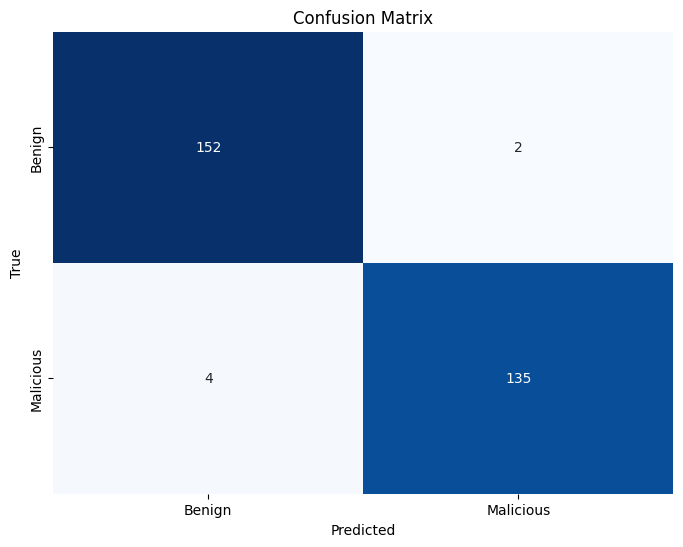

In [15]:
y_test_tensor = torch.tensor(y_test.numpy())
y_pred_test_tensor = torch.tensor(y_pred_test.numpy())
cm = custom_confusion_matrix(y_test_tensor, y_pred_test_tensor)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Benign", "Malicious"],
            yticklabels=["Benign", "Malicious"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
y_true_np = y_test.numpy()
y_pred_test_np = y_pred_test.numpy()

target_names = ["Benign", "Malicious"]

print("Classification Report:")
print(classification_report(y_true_np, y_pred_test_np, target_names=target_names))


Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.99      0.98       154
   Malicious       0.99      0.97      0.98       139

    accuracy                           0.98       293
   macro avg       0.98      0.98      0.98       293
weighted avg       0.98      0.98      0.98       293



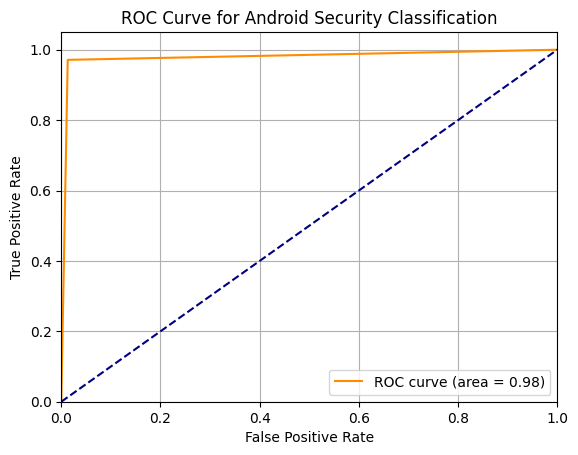

In [17]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Android Security Classification')
plt.legend()
plt.grid()
plt.show()
